# Compressed Sensing

In [2]:
import numpy as np
import scipy as sc
import cvxpy as cp
from numba import jit, float64
import matplotlib.pyplot as plt

Problem:
$$\textrm{minimize} \left\lVert x \right\rVert _1 \textrm{subject to } Ax=b$$
or
$$\textrm{minimize} \left\lVert x \right\rVert _1 + \delta_{b}(Ax)$$

## First attempt: Chambolle-Pock algorithm

Algorithm for a problem $\textrm{minimize} f(x) + g(Ax)$:
$$x_{n+1} = \mathrm{prox}_{\lambda f}(x_n - \lambda A^T\omega_n)$$
$$w_{n+1} = \mathrm{prox}_{\beta g^*}(\omega_n+\beta A(2x_{n+1}-x_n)) $$
where $g^*(x^*) = \langle x^*, b \rangle$

In [5]:
# prox_{\lambda f}
@jit
def prox_f(x, step):
    vec = np.abs(x) - step
    vec[vec<0] = 0
    return np.sign(x)*vec


#prox_{\sigma g*}
@jit
def prox_g(x, b, step):
    return x - step*b

In [6]:
def l1_chambolle_pock(A, b, lambd, beta, N, **kwargs):
    x = kwargs.get('x0', np.zeros(A.shape[1]))
    omega = kwargs.get('omega0', np.zeros(A.shape[0]))
    sol = chambolle_pock(A, b, lambd, beta, N, x, omega)
    return sol

@jit
def chambolle_pock(A, b, lambd, beta, N, x, omega):
    A_t = A.T
    x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
    omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
    n = 1
    while n < N:
        x = x_next
        omega = omega_next
        x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
        omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
        n += 1
        # print("m = {}  {}% done".format(len(b), round(n/N*100, 2)), end='\r', flush=True)
    return x_next

In [4]:
@jit
def chambolle_pock(A, b, lambd, beta, N, x, omega):
    A_t = A.T
    x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
    omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
    n = 1
    while n < N:
        x = x_next
        omega = omega_next
        x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
        omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
        n += 1
        # print("m = {}  {}% done".format(len(b), round(n/N*100, 2)), end='\r', flush=True)
    return x_next

A quick check of convergence

In [8]:
x_test = np.array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])
A_test = np.random.normal(size=(8, 10))
y_test = np.matmul(A_test, x_test)
xs_test = [l1_chambolle_pock(A_test, y_test, 0.05, 0.05, N) for N in [300, 400, 500, 600, 700, 800, 900, 1000]]

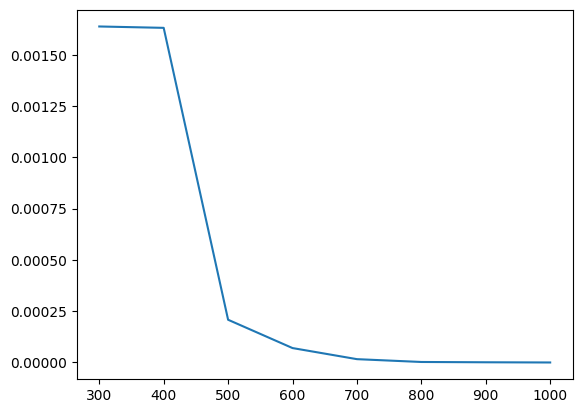

In [9]:
plt.plot([300, 400, 500, 600, 700, 800, 900, 1000], [np.linalg.norm(xx-x_test) for xx in xs_test])

$2s \log{\frac{N}{s}} + \frac{5}{4}s + 1$ random Gaussian measurements suffice to recover the s-sparse vector

In [11]:
s = 10
N = 100
2*s*np.log(N/s) + 5/4*s + 1

np.float64(59.55170185988092)

Running 10 tests for a fixed $s$ and comparing to the estimate

In [54]:
x = np.zeros(100)
x[np.random.choice(range(0, 100), size=5, replace=False)] = np.random.randint(0, 2, 5)*2-1
ms = np.linspace(1, 100, 50, dtype=int)
As = [[np.random.normal(size=(m, 100)) for m in ms] for i in range(10)]
ys = [[np.matmul(A, x) for A in A_sizes]for A_sizes in As]
x

array([ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [55]:
solutions2 = []
for (A_sizes, y_sizes) in zip(As, ys):
    for (A, y) in zip(A_sizes, y_sizes):
        sol = cp.Variable(shape=x.shape)
        constr = [A@sol == y]
        obj = cp.Minimize(cp.norm(sol, 1))
        prob = cp.Problem(obj, constr)
        prob.solve()
        solutions2.append(sol.value)
solutions2 = np.array(solutions2).reshape((len(As), len(As[0]), x.shape[0]))

In [56]:
errors = np.array([[np.linalg.norm(sol - x) for sol in solutions_sizes] for solutions_sizes in solutions2])
success = np.zeros(errors.shape)
success[errors<0.0001] = 1
success.sum(axis=0)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  7.,  6., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

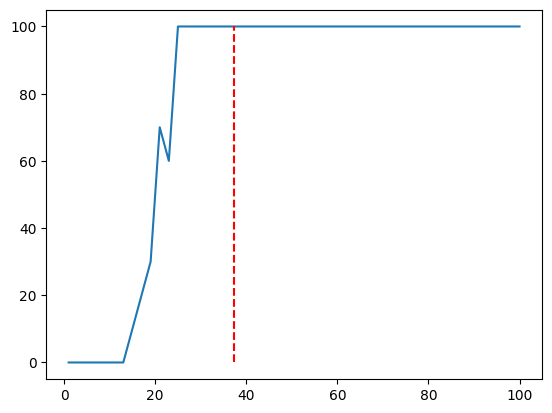

In [57]:
plt.plot(ms, success.sum(axis=0)/10*100)
s = 5
N = 100
plt.vlines(2*s*np.log(N/s) + 5/4*s + 1, ymin=0, ymax=100, colors='red', linestyles='dashed')
plt.savefig("log_estimate_s5")

Now adding varying $s$ (still using Chambolle-Pock)

In [ ]:
'''
A: axis0 - varying m
   axis1 - different random matrices
x: axis0 - varying s
y: axis0 - varying s
   axis1 - varying m
   axis2 - different random matrices
'''

In [16]:
def phase_trans(dim, sparse_step, mesure_step, n_of_tests, n_iter=5000):

    x = np.zeros(shape=(dim//sparse_step+1, dim))
    for i in range(0, dim//sparse_step+1):
        non_sparse = np.random.choice(range(0, dim), size = i*sparse_step, replace=False)
        x[i, non_sparse] = np.random.randint(0, 2, size=non_sparse.shape[0])*2-1
    ms = np.linspace(mesure_step, dim, dim//mesure_step, dtype=int)
    As = [[np.random.normal(size=(m, dim)) for i in range(n_of_tests)] for m in ms]
    ys = [[[np.matmul(A, x_s) for A in As[i]] for i in range(len(ms))] for x_s in x]

    solutions = np.zeros((x.shape[0], len(ms), len(As[0]), dim))

    count = 0 
    for i in range(len(x)):
        for j in range(len(ms)):
            for k in range(n_of_tests):
                solutions[i][j][k] = l1_chambolle_pock(As[j][k], ys[i][j][k], 0.01, 0.01, N=n_iter)
                # print(f"s = {i*sparse_step:3d}, m = {(j+1)*mesure_step:3d}, test #{k:3d}/{n_of_tests}")
                count += 1
                if count%10==0: 
                    print("{:2f}% done".format(count/(len(x)*len(ms)*n_of_tests)*100), end='\r')

    return solutions, x
    

In [ ]:
res, x = phase_trans(100, 1, 1, 10, n_iter=10000)

In [65]:
error = np.zeros(res.shape[:-1])
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            error[i, j, k] = np.linalg.norm(res[i, j, k] - x[i])
is_successful = np.zeros(res.shape[:-1])
is_successful[error<0.001] = 1
is_successful.sum(axis=2)

array([[10., 10., 10., ..., 10., 10., 10.],
       [ 0.,  2.,  0., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(101, 100))

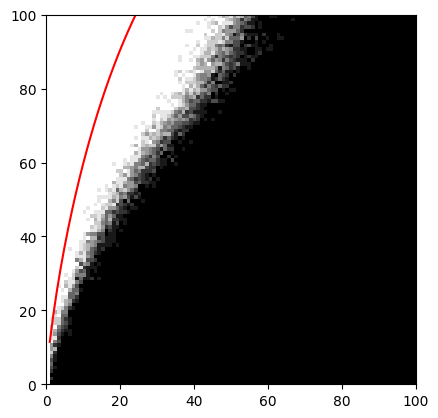

In [66]:
s = np.linspace(1, 100, 100)
crit = 2*s*np.log(100/s) + 5/4*s + 1
plt.plot(s, crit, c='red')
plt.imshow(is_successful.sum(axis=2).T, cmap='binary', extent=[0, 100, 0, 100], origin='lower')
plt.show()

Convergence is slow so it's time to use `cvxpy` library

## Second attempt: `cvxpy`

In [3]:
import cvxpy as cp

In [3]:
def phase_trans_cvxpy(dim, sparse_step, mesure_step, n_of_tests):

    x = np.zeros(shape=(dim//sparse_step+1, dim))
    for i in range(0, dim//sparse_step+1):
        non_sparse = np.random.choice(range(0, dim), size = i*sparse_step, replace=False)
        x[i, non_sparse] = np.random.randint(-100, 100, size=non_sparse.shape[0])
    ms = np.linspace(mesure_step, dim, dim//mesure_step, dtype=int)
    As = [[np.random.normal(size=(m, dim)) for i in range(n_of_tests)] for m in ms]
    ys = [[[np.matmul(A, x_s) for A in As[i]] for i in range(len(ms))] for x_s in x]

    solutions = np.zeros((x.shape[0], len(ms), len(As[0]), dim))

    count = 0 
    for i in range(len(x)):
        for j in range(len(ms)):
            for k in range(n_of_tests):
                sol = cp.Variable(shape=x.shape[1])
                constr = [As[j][k]@sol == ys[i][j][k]]
                obj = cp.Minimize(cp.norm(sol, 1))
                prob = cp.Problem(obj, constr)
                prob.solve()
                solutions[i][j][k] = sol.value
                # print(f"s = {i*sparse_step:3d}, m = {(j+1)*mesure_step:3d}, test #{k:3d}/{n_of_tests}")
                count += 1
                if count%10==0: 
                    print("{:2f}% done".format(count/(len(x)*len(ms)*n_of_tests)*100), end='\r')

    return solutions, x

In [30]:
res_cvxpy, x_cvxpy = phase_trans_cvxpy(100, 1, 1, 10)
# np.save("dim100_num_solutions.npy", res_cvxpy)
# np.save("dim100_true_solution.npy", x_cvxpy)

/home/lizardwizard/venv-math/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
res_cvxpy100, x_cvxpy100 = phase_trans_cvxpy(100, 1, 1, 10)
np.save("dim100_num_solutions.npy", res_cvxpy100)
np.save("dim100_true_solution.npy", x_cvxpy100)

In [4]:
res_cvxpy = np.load("dim100_num_solutions.npy")
x_cvxpy = np.load("dim100_true_solution.npy")

In [5]:
error_cvxpy = np.zeros(res_cvxpy.shape[:-1])
for i in range(res_cvxpy.shape[0]):
    for j in range(res_cvxpy.shape[1]):
        for k in range(res_cvxpy.shape[2]):
            error_cvxpy[i, j, k] = np.linalg.norm(res_cvxpy[i, j, k] - x_cvxpy[i])
is_successful = np.zeros(res_cvxpy.shape[:-1])
is_successful[error_cvxpy<0.0001] = 1
is_successful.sum(axis=2)

array([[10., 10., 10., ..., 10., 10., 10.],
       [ 0.,  0.,  1., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  0., 10.]], shape=(101, 100))

### "The Convex Geometry..."

Text(0, 0.5, 'Number of measurements, $m$')

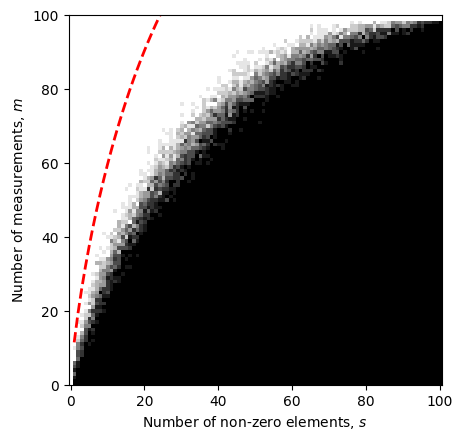

In [6]:
plt.imshow(is_successful.sum(axis=2).T, cmap="binary_r", origin="lower")
s = np.linspace(1, 100, 100)
crit = 2*s*np.log(100/s) + 5/4*s + 1
plt.plot(s, crit, 'r--', lw=2)
plt.ylim(0,100)
plt.xlabel("Number of non-zero elements, $s$")
plt.ylabel("Number of measurements, $m$")
# plt.savefig("report/pictures/log_estimate.png", dpi=300, bbox_inches='tight')

### "Living on the Edge"

In [2]:
from math import erf

In [3]:
def eq46(tau, ro):
    return np.sqrt(2/np.pi)/tau*np.e**(-0.5*tau**2) - (1-erf(tau*np.sqrt(0.5))) - ro/(1-ro)

def psi(ro, tau):
    integral =  (1+tau**2)*(1-erf(tau*np.sqrt(0.5))) - np.sqrt(2/np.pi)*tau*np.e**(-tau**2*0.5)
    return ro*(1+tau**2) + (1-ro)*integral

In [7]:
s = np.linspace(1, 299, 99)
psi_ro = np.zeros(99)
for i in range(99):
    tau_opt = sc.optimize.root_scalar(lambda tau: eq46(tau, s[i]/300), bracket=(0.0001, 5)).root
    psi_ro[i] = psi(s[i]/300, tau_opt)

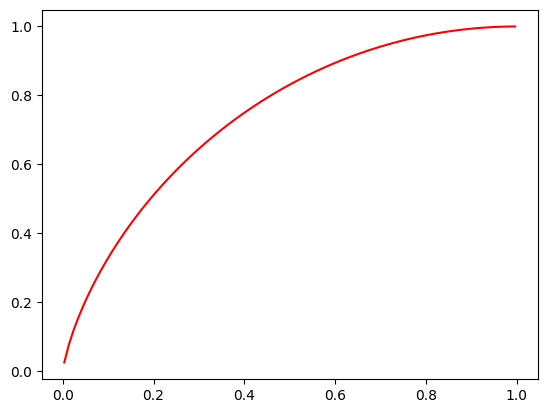

In [13]:
plt.plot(s/300, psi_ro, c='red')

In [14]:
stat_dim_lower = 100*psi_ro - 100*2/np.sqrt(s*100)
stat_dim_upper = 100*psi_ro

Text(0, 0.5, 'Number of measurements, $m$')

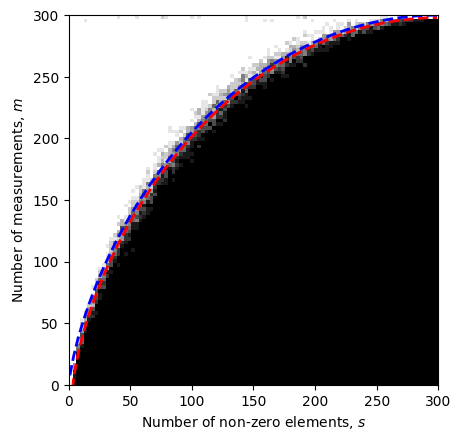

In [15]:
plt.plot(s, stat_dim_lower, 'r--', linewidth=2)
plt.plot(s, stat_dim_upper, 'b--', linewidth=2)
plt.imshow(is_successful.sum(axis=2).T, cmap='binary_r', extent=[0, 100, 0, 100], origin='lower')
plt.xlabel("Number of non-zero elements, $s$")
plt.ylabel("Number of measurements, $m$")
plt.savefig("report/pictures/statistical_dimension.png", dpi=300, bbox_inches='tight')

In [19]:
def transition_phase(prob, s, dim):
    # s = np.linspace(1, dim-1, N_points-1)
    psi_ro = np.zeros(s.shape)
    for i in range(s.shape[0]):
        tau_opt = sc.optimize.root_scalar(lambda tau: eq46(tau, s[i]/dim), bracket=(0.0001, 5)).root
        psi_ro[i] = psi(s[i]/dim, tau_opt)
    stat_dim_lower = dim * psi_ro - dim * 2 / np.sqrt(s * dim)
    stat_dim_upper = dim * psi_ro
    m_success = (stat_dim_upper+stat_dim_lower)/2 + np.sqrt(8*np.log(4/prob))*np.sqrt(dim)
    m_fail = (stat_dim_upper+stat_dim_lower)/2 - np.sqrt(8*np.log(4/prob))*np.sqrt(dim)
    return m_success, m_fail, stat_dim_lower, stat_dim_upper

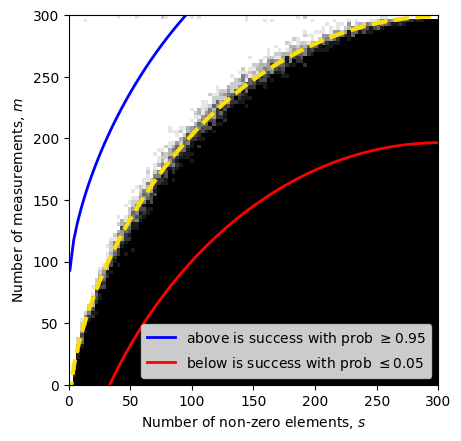

In [27]:
eta = 0.05
m_success, m_fail, stat_dim_lower, stat_dim_upper = transition_phase(eta, dim=300)
s = np.linspace(1, 300, 99)
plt.plot(s, m_success, c='blue', label=f"above is success with prob $\\geq {round(1-eta, 2)}$", lw=2)
plt.plot(s, m_fail, c='red', label=f"below is success with prob $\\leq {eta}$", lw=2)
plt.plot(s, (stat_dim_upper+stat_dim_lower)/2, '--', color="#fcdf03", linewidth=3)
plt.xlabel("Number of non-zero elements, $s$")
plt.ylabel("Number of measurements, $m$")
plt.imshow(is_successful.sum(axis=2).T, cmap='binary_r', extent=(0, 300, 0, 300), origin='lower')
plt.legend(loc="lower right")
plt.savefig("report/pictures/lote_estimates_d300.png", dpi=300, bbox_inches='tight')

### Comparison

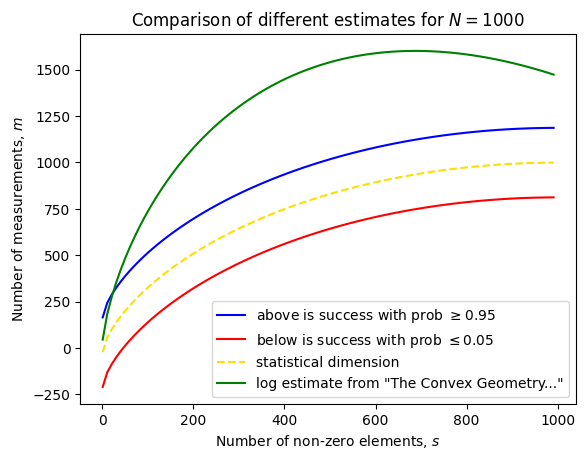

In [29]:
eta = 0.05
N=1000
s = np.arange(1, N, 10)

A = np.sqrt(np.log(eta**(-2))) + np.sqrt(2*s*np.log(N/s)+5/4*s)
ms_log = 0.5*(A**2 + A*np.sqrt(A**2 + 4*A))
m_success, m_fail, stat_dim_lower, stat_dim_upper = transition_phase(eta, s, dim=N)

plt.plot(s, m_success, "b-", label=f"above is success with prob $\\geq {round(1-eta, 2)}$")
plt.plot(s, m_fail, "r-", label=f"below is success with prob $\\leq {eta}$")
plt.plot(s, (stat_dim_lower+stat_dim_upper)/2, "--", color="#fcdf03", label="statistical dimension")
crit = 2*s*np.log(1000/s) + 5/4*s + 1
plt.plot(s, ms_log, 'g-', label="log estimate from \"The Convex Geometry...\"")
plt.legend()
plt.xlabel("Number of non-zero elements, $s$")
plt.ylabel("Number of measurements, $m$")
plt.title(f"Comparison of different estimates for $N={N}$")
plt.savefig(f"report/pictures/compare_estimates{N}.png", dpi=300, bbox_inches='tight')

### Bonus: probability from "The Convex Geometry"

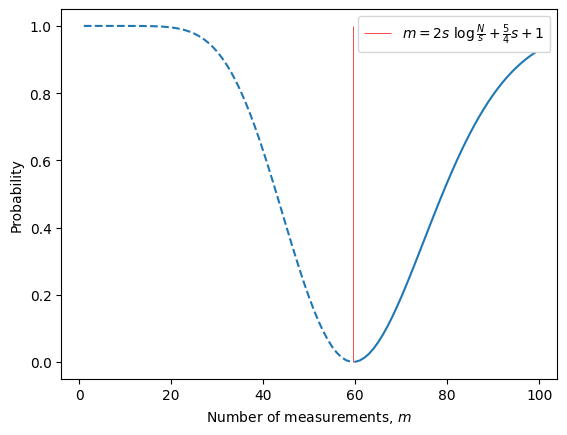

In [7]:
N=100
s=10
M = np.arange(1, N, 1)
Y1 = (M/np.sqrt(M+1) - np.sqrt(2*s*np.log(N/s) + 5/4*s))**2
t = 2*s*np.log(N/s) + 5/4*s +1
plt.plot(M[M<t], 1-np.e**(-0.5*Y1[M<t]), color="tab:blue", linestyle='--')
plt.plot(M[M>=t], 1-np.e**(-0.5*Y1[M>=t]))
plt.vlines(2*s*np.log(N/s) + 5/4*s +1, 0, 1, colors='red', linewidth=0.5, label=r'$m = 2s~\log \frac{N}{s} + \frac{5}{4}s + 1$')
plt.xlabel('Number of measurements, $m$')
plt.ylabel('Probability')

plt.legend()
# plt.savefig("report/pictures/log_proba100.png", dpi=300, bbox_inches='tight')